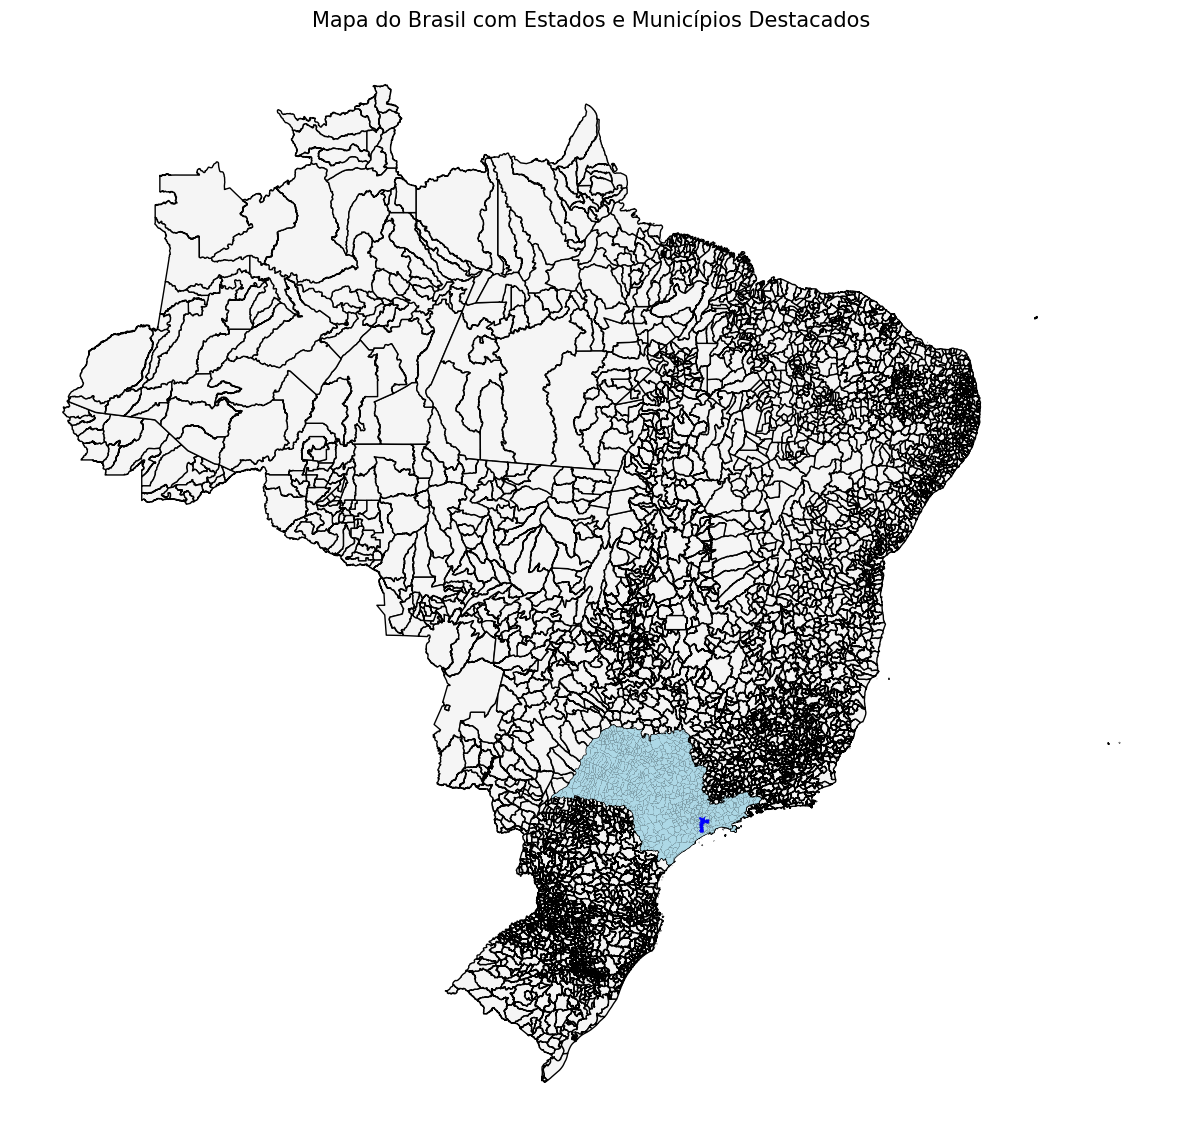

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# Carregar dados geoespaciais do Brasil
path_to_shapefiles = 'shapefiles'

# Carregar os shapefiles
brasil_regions = gpd.read_file('Mapa/BR_Municipios_2022.shp')

# Configuração do gráfico
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plotar os municípios do Brasil
brasil_regions.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Destacar um estado específico (exemplo: São Paulo)
sao_paulo_state = brasil_regions[brasil_regions['SIGLA_UF'] == 'SP']
sao_paulo_state.plot(ax=ax, color='lightblue')

# Destacar uma cidade específica (exemplo: São Paulo)
sao_paulo_city = brasil_regions[brasil_regions['NM_MUN'] == 'São Paulo']
sao_paulo_city.plot(ax=ax, color='blue')

# Adicionar título e remover eixos
ax.set_title('Mapa do Brasil com Estados e Municípios Destacados', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

plt.show()

# Criar um mapa interativo usando folium
mapa_brasil = folium.Map(location=[-15.788497, -47.879873], zoom_start=4)

# Adicionar os municípios do Brasil ao mapa
folium.GeoJson(brasil_regions, name='Municípios').add_to(mapa_brasil)

# Adicionar uma cidade específica (exemplo: São Paulo) ao mapa
folium.Marker(location=[-23.55052, -46.633308], popup='São Paulo').add_to(mapa_brasil)

# Mostrar o mapa interativo
mapa_brasil.save('mapa_brasil.html')
mapa_brasil


In [7]:
import geopandas as gpd
import folium
from folium import GeoJson
from folium.plugins import Search
from branca.element import Template, MacroElement

# Carregar dados geoespaciais do Brasil
path_to_shapefiles = 'shapefiles'
brasil_municipios = gpd.read_file('Mapa/BR_Municipios_2022.shp')

# Criar um mapa interativo usando folium
mapa_brasil = folium.Map(location=[-15.788497, -47.879873], zoom_start=4)

# Adicionar estados ao mapa com possibilidade de clicar para dar zoom
for estado in brasil_municipios['SIGLA_UF'].unique():
    estado_data = brasil_municipios[brasil_municipios['SIGLA_UF'] == estado]
    geojson = GeoJson(
        data=estado_data,
        style_function=lambda feature: {
            'fillColor': 'lightblue',
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5',
            'fillOpacity': 0.7,
        },
        highlight_function=lambda feature: {
            'fillColor': 'blue',
            'color': 'blue',
            'weight': 2,
            'dashArray': '1, 1',
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(fields=['NM_MUN', 'SIGLA_UF'], aliases=['Município', 'Estado']),
    )
    
    geojson.add_to(mapa_brasil)

# Função para adicionar controle de seleção de estados e cidades
selection_control = """
{% macro html(this, kwargs) %}
<div id="selectionControl" style="position: fixed; 
    top: 50px; left: 50px; width: 200px; height: auto; 
    background-color: white; z-index: 9999; font-size: 14px;">
    <h4>Selecionar Estado</h4>
    <select id="stateSelect" onchange="zoomToState()">
        <option value="">Selecione um estado</option>
        {% for estado in this.estados %}
        <option value="{{estado}}">{{estado}}</option>
        {% endfor %}
    </select>
    <br>
    <h4>Selecionar Município</h4>
    <select id="citySelect" onchange="zoomToCity()">
        <option value="">Selecione um município</option>
        {% for municipio in this.municipios %}
        <option value="{{municipio}}">{{municipio}}</option>
        {% endfor %}
    </select>
    <br>
    <button onclick="resetMap()">Voltar ao Brasil</button>
</div>

<script>
function zoomToState() {
    var state = document.getElementById('stateSelect').value;
    if (state) {
        var stateBounds = {{ this.state_bounds|tojson }};
        var bounds = stateBounds[state];
        if (bounds) {
            map.fitBounds(bounds);
        }
    }
}

function zoomToCity() {
    var city = document.getElementById('citySelect').value;
    if (city) {
        var cityBounds = {{ this.city_bounds|tojson }};
        var bounds = cityBounds[city];
        if (bounds) {
            map.fitBounds(bounds);
        }
    }
}

function resetMap() {
    map.setView([-15.788497, -47.879873], 4);
}
</script>
{% endmacro %}
"""

# Extrair limites de estados e municípios
state_bounds = {}
city_bounds = {}
for estado in brasil_municipios['SIGLA_UF'].unique():
    estado_data = brasil_municipios[brasil_municipios['SIGLA_UF'] == estado]
    state_bounds[estado] = estado_data.total_bounds[[1, 0, 3, 2]].tolist() # [miny, minx, maxy, maxx]

for municipio in brasil_municipios['NM_MUN'].unique():
    municipio_data = brasil_municipios[brasil_municipios['NM_MUN'] == municipio]
    city_bounds[municipio] = municipio_data.total_bounds[[1, 0, 3, 2]].tolist() # [miny, minx, maxy, maxx]

macro = MacroElement()
macro._template = Template(selection_control)
macro.add_to(mapa_brasil)

# Adicionar as opções diretamente ao macro
macro.estados = list(brasil_municipios['SIGLA_UF'].unique())
macro.municipios = list(brasil_municipios['NM_MUN'].unique())
macro.state_bounds = state_bounds
macro.city_bounds = city_bounds

mapa_brasil.get_root().add_child(macro)

# Mostrar o mapa interativo
mapa_brasil.save('mapa_brasil.html')
mapa_brasil
